## This GitHub repository is developed as part of the publication:
#
#  __Open-Source Pre-Clinical Image Segmentation: Mouse cardiac MRI datasets with a deep learning segmentation framework__
#
# submitted to the Journal of Cardiovascular Magnetic Resonance

# --------------------------------------------------------------

In this paper, we present the first publicly-available pre-clinical cardiac MRI dataset, along with an open-source DL segmentation model and a web-based interface for easy deployment (available at https://huggingface.co/spaces/mrphys/Pre-clinical_DL_segmentation).

This GitHub repository contains the dataset and open-sourse model.

This dataset comprises of complete cine short-axis cardiac MRI images from 130 mice with diverse phenotypes.
It also contains expert manual segmentations of left ventricular (LV) blood pool and myocardium at end-diastole, end-systole, as well as additional timeframes with artefacts to improve robustness.

Using this resource, we developed an open-source DL segmentation model based on the UNet3+ architecture, with the training and inference code below.

# --------------------------------------------------------------

## Step 1: Install or upgrade dependencies

🔧 Setup Guide
--------------------------------------------------------------------------------
Follow these steps to prepare your environment and install the required packages.
<!-- tensorflow==2.10
protobuf==3.19.6
albumentations>=2 -->


💡 Tip:
Inside Jupyter/Colab notebooks, use %pip (magic command).
In a terminal or Python script, drop the `%`. 

✏️ **Note:** The loss used only works with Keras 2.x

```bash

# Matplotlib ≥ 3.5 recommended (older versions may error in plotting)
%pip install --quiet --upgrade matplotlib

# Augmentation library
%pip install --quiet albumentations

In [1]:
# ========== CUDA/GPU selection (optional) ==========
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import os
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.utils import to_categorical
import albumentations as A

# ========== Local ==========
from losses import *
from unet3plus import *
from utility import *

/Users/jennifersteeden/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# --------------------------------------------------------------
## Step 2: Load the Dataset

In this step, we load the cine MRI data and segmentation masks stored in `Mouse*.h5` files.  
Each H5 file contains:
- **Images**: cine MR frames in shape `(H, W, S, F)`
- **Masks**: segmentation maps with labels {0 = background, 1 = myocardium, 2 = blood}
- **Frames_with_ROI**: indices of frames that were manually segmented  
  - Usually **two frames**: End-Diastole (ED) and End-Systole (ES)  
  - Some mice also have **inflow artifact frames** segmented (ED + ES + Inflow)  

The function `load_roi_data_from_h5_folder()`:
- Reads all H5 files in the folder  
- Extracts slices from ED/ES frames (and inflow frames if present)  
- Keeps **all slices** from those frames, even apical/basal slices with no ROI  
- Returns arrays for 2D images and masks, along with filenames, per-patient metadata (frame indices, full cine volumes, full masks), and QC checks. 


After loading, we call `summarise_mice_and_masks()` to:
- Print the number of patients with ED+ES only vs ED+ES+Inflow  
- Report dataset statistics (total slices, ROI-labeled slices, patients)  
- Check that all masks only contain valid labels {0,1,2} 

✏️ **Note:**  
Replace path to h5_folder with the directory where **your own `Mouse*.h5` files** are stored.  

In [2]:
# Path to the folder containing all Mouse*.h5 files
cwd = os.getcwd()
h5_folder = cwd+'/Data' 

# Load images, masks, filenames, and metadata from the H5 files
# NOTE: images and masks contain the 2D images from the timepoints with ROIS only in the dataset provided, 
# whereas all_volumes and all_masks contain all timepoints

images, masks, filenames, relevant_frames, all_volumes, all_masks, masks_check = \
    load_roi_data_from_h5_folder(h5_folder)

# Print dataset summary (patients with ED/ES frames, inflow cases, mask checks)
summarise_mice_and_masks(relevant_frames, masks_check)


Patients with ED+ES+Inflow: 4
   Mouse17
   Mouse48
   Mouse91
   Mouse125

Patients with ED+ES only: 126
   Mouse1
   Mouse2
   Mouse3
   Mouse4
   Mouse5
   Mouse6
   Mouse7
   Mouse8
   Mouse9
   Mouse10
   Mouse11
   Mouse12
   Mouse13
   Mouse14
   Mouse15
   Mouse16
   Mouse18
   Mouse19
   Mouse20
   Mouse21
   Mouse22
   Mouse23
   Mouse24
   Mouse25
   Mouse26
   Mouse27
   Mouse28
   Mouse29
   Mouse30
   Mouse31
   Mouse32
   Mouse33
   Mouse34
   Mouse35
   Mouse36
   Mouse37
   Mouse38
   Mouse39
   Mouse40
   Mouse41
   Mouse42
   Mouse43
   Mouse44
   Mouse45
   Mouse46
   Mouse47
   Mouse49
   Mouse50
   Mouse51
   Mouse52
   Mouse53
   Mouse54
   Mouse55
   Mouse56
   Mouse57
   Mouse58
   Mouse59
   Mouse60
   Mouse61
   Mouse62
   Mouse63
   Mouse64
   Mouse65
   Mouse66
   Mouse67
   Mouse68
   Mouse69
   Mouse70
   Mouse71
   Mouse72
   Mouse73
   Mouse74
   Mouse75
   Mouse76
   Mouse77
   Mouse78
   Mouse79
   Mouse80
   Mouse81
   Mouse82
   Mouse83
   Mouse84


# --------------------------------------------------------------
## Step 3: Set Model Identifier & Segmentation Classes

Before training, define:
- **model name** (used in checkpoint filenames and experiment tracking), and
- number of **segmentation classes** the network should predict.

### Model name
`model_name` tags your run and the saved checkpoint (e.g., `models/SEG_1.h5`) so you can tell runs apart later.

### Segmentation classes (multi-class)
We perform **multi-class segmentation** on cine MRI short-axis slices with three classes:
- **0** → Background (everything outside the heart)  
- **1** → Myocardium (heart muscle)  
- **2** → Blood pool (LV cavity)


In [3]:
# Identifier/name for the segmentation model
model_name = 'SEG_1'

# Number of classes for segmentation
num_classes = 3

# --------------------------------------------------------------
## Step 4: Explore Data (Optional — can skip to Step 5)

Before moving on to training/validation splits, it can be useful to **visualize and sanity-check** the dataset.  
This step is optional — you can **skip directly to Step 5 (Train/Val/Test split)**.

The helper function `plot_pixel_value_histogram()` allows you to:
- Select a **mouse**, **slice**, and **frame** (ED or ES) from the dataset.  
- Display the **original image** paired with its **segmentation mask**, for each class:  
  - **0 = Background**  
  - **1 = Myocardium**  
  - **2 = Blood pool**  

This step is mainly for **quality control** and to verify that images/masks look as expected.


Selected: Mouse4 (slice=5, frame=0)
Shape (H, W, S, F): (256, 256, 9, 22)
Image dtype: uint16 Mask dtype: uint8
Raw mask values: [0 1 2]


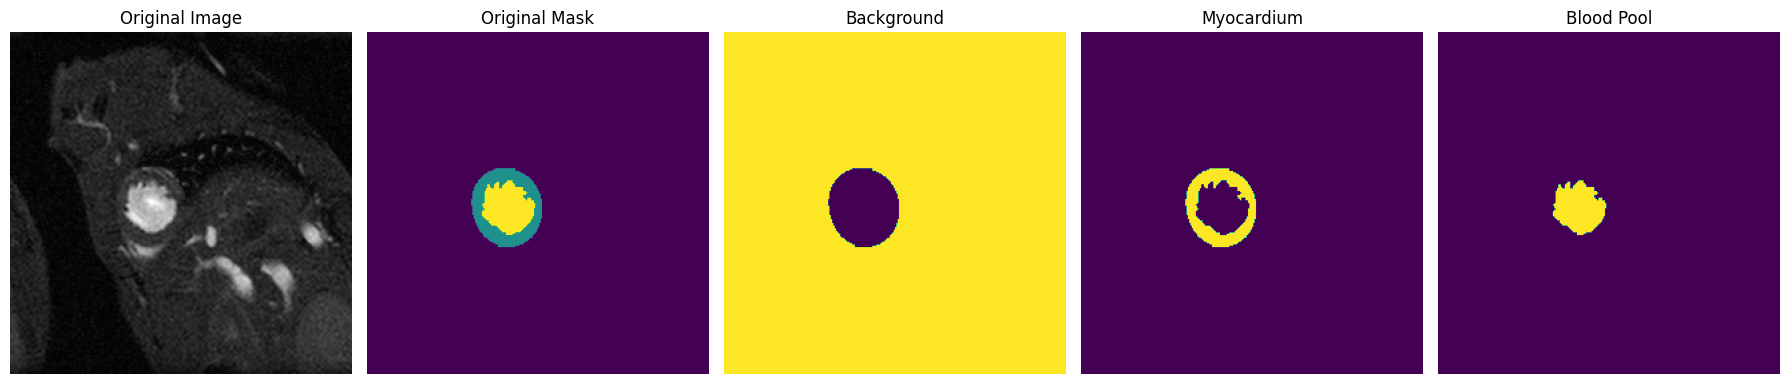

In [4]:
# Plot an image slice and its mask pair for a specific mouse, slice, and frame (for QC/visualization)
%matplotlib inline

plot_dicom_with_mask(mouse_index=3, slice_number=5, frame_index=0)

# --------------------------------------------------------------
## Step 5: Create Train/Validation/Test Splits

To properly evaluate model performance, we need to split the dataset into **training**, **validation**, and **testing** sets.  
Splitting is done **by mouse ID** (not by slice), to avoid *data leakage* — otherwise slices from the same mouse could appear in both training and testing sets.

- **Training set**: used to fit the unet3plus model parameters.  
- **Validation set**: used to tune hyperparameters and monitor overfitting during training.  
- **Test set**: held out until the very end for unbiased performance evaluation.  

In this case:
- 90 mice are used for training,  
- 15 mice for validation,  
- 25 mice for testing.  
We also shuffle the list of mice with a fixed random seed (`np.random.seed(42)`) for reproducibility. 


✏️ **Note:**  In this dataset, 4 mice contain **ED+ES+Inflow** segmentations:
(`Mouse17`, `Mouse48`, `Mouse91`, `Mouse125`)   
In the paper, we kept these in the training set since they provide **additional** inflow frames compared to ED/ES-only mice.  


In [5]:
# Get the list of unique mice from the filenames (MouseID, slice, frame)
all_mice = sorted(set(
    parse_filename(f)[0] for f in filenames
))

# Define how many mice will go into training, validation, and test sets
num_train = 90
num_val   = 15
num_test  = 25
# Safety check: make sure the split covers all mice
assert num_train + num_val + num_test == len(all_mice), "Mismatch in mouse count"

# Shuffle the mouse list with a fixed random seed for reproducibility
np.random.seed(42)
shuffled_mice = np.array(all_mice)
np.random.shuffle(shuffled_mice)

# Assign mice into train, val, and test sets
train_mice = shuffled_mice[:num_train].tolist()
val_mice   = shuffled_mice[num_train:num_train + num_val].tolist()
test_mice  = shuffled_mice[num_train + num_val : num_train + num_val + num_test].tolist()

# Separate the images/masks into train/val/test based on which mouse they belong to
train_images, train_masks, train_metadata = [], [], []
val_images, val_masks, val_metadata       = [], [], []
test_images, test_masks, test_metadata    = [], [], []

for img, msk, fname in zip(images, masks, filenames):
    mouse_id, slice_number, frame_number = parse_filename(fname)
    metadata_tuple = (mouse_id, slice_number, frame_number)

    if mouse_id in train_mice:
        train_images.append(img)
        train_masks.append(msk)
        train_metadata.append(metadata_tuple)
    elif mouse_id in val_mice:
        val_images.append(img)
        val_masks.append(msk)
        val_metadata.append(metadata_tuple)
    elif mouse_id in test_mice:
        test_images.append(img)
        test_masks.append(msk)
        test_metadata.append(metadata_tuple)

# Convert lists to NumPy arrays so they can be used directly in model training
train_images = np.array(train_images)
train_masks  = np.array(train_masks)
val_images   = np.array(val_images)
val_masks    = np.array(val_masks)
test_images  = np.array(test_images)
test_masks   = np.array(test_masks)


# --------------------------------------------------------------
## Step 6: Verify Dataset Split (Optional — can skip to Step 7)

After creating the train/validation/test splits, it’s good practice to **double-check** that the data has been partitioned correctly.  
This step is optional — you can **skip directly to Step 7 (Data Augmentation)**.

The helper function `train_val_test_dis()` prints a summary of the dataset split:

- Total number of mice in the dataset.  
- How many mice are assigned to training, validation, and testing sets.  
- Shapes of the image and mask arrays in each split.  
- The actual mouse IDs included in each subset.  

This step is mainly for **quality control** to ensure there is no overlap between sets and that the split sizes match what you intended.

In [6]:
# Display a summary of the dataset split:
#   - Number of mice in train/val/test sets
#   - Shapes of images and masks in each split
#   - Which mouse IDs were assigned to each set
train_val_test_dis(
    all_mice,
    train_mice, val_mice, test_mice,
    train_images, train_masks,
    val_images,   val_masks,
    test_images,  test_masks,
)


Dataset distribution (n = 130):
Number of training mice: 90
Number of validation mice: 15
Number of test mice: 25

All images shape: (2833, 256, 256)
All masks shape:  (2833, 256, 256)
Training set images shape: (1858, 256, 256)
Training set masks shape: (1858, 256, 256)
Validation set images shape: (280, 256, 256)
Validation set masks shape: (280, 256, 256)
Test set images shape: (695, 256, 256)
Test set masks shape: (695, 256, 256)

Training mice:
  Mouse1
  Mouse2
  Mouse3
  Mouse4
  Mouse7
  Mouse8
  Mouse9
  Mouse11
  Mouse13
  Mouse14
  Mouse16
  Mouse17
  Mouse18
  Mouse20
  Mouse21
  Mouse22
  Mouse23
  Mouse24
  Mouse26
  Mouse27
  Mouse28
  Mouse30
  Mouse31
  Mouse32
  Mouse37
  Mouse38
  Mouse40
  Mouse41
  Mouse42
  Mouse43
  Mouse44
  Mouse45
  Mouse47
  Mouse48
  Mouse50
  Mouse51
  Mouse52
  Mouse53
  Mouse54
  Mouse55
  Mouse57
  Mouse58
  Mouse59
  Mouse62
  Mouse66
  Mouse67
  Mouse68
  Mouse69
  Mouse70
  Mouse72
  Mouse73
  Mouse76
  Mouse77
  Mouse81
  Mouse83
  

# --------------------------------------------------------------
## Step 7: Data Augmentation

To improve model generalization and mimic real-world variability, we apply **on-the-fly data augmentation** during training.  
This helps the UNet3+ model become more robust to:
- Orientation differences across scans,  
- Noise and artifacts introduced during acquisition,  
- Intensity/contrast variations that occur across **different MRI scanners or protocols**. 

We use the **Albumentations** library to define a transformation pipeline. Each transformation is applied randomly with the probability `p`.

The pipeline includes:
- **HorizontalFlip** → randomly mirror the image left-right.  
- **RandomRotate90** → randomly rotate by 90°, 180°, or 270°.  
- **RandomBrightnessContrast** → adjust brightness by up to ±17%, simulating differences in scanner calibration.  
- **RandomGamma** → nonlinear intensity scaling, simulating scans from different MRI vendors or acquisition protocols.  
- **GaussNoise** → add Gaussian noise to simulate acquisition noise.  
- **CLAHE** → adaptive histogram equalization to locally enhance contrast, improving robustness to low-quality or heterogeneous scans.  
- **ShiftScaleRotate** → random affine transformations (translation ±6.25%, scaling ±10%, rotation ±10°), simulating slight misalignments during acquisition.  

These augmentations are applied **only to the training set**
Validation and test sets are left untouched to ensure unbiased evaluation.

In [7]:
# Define the Albumentations augmentation pipeline.
# These transformations are applied randomly during training to improve model generalization and mimic real-world variability.

augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),                 # 50% chance to flip image left-right
    A.RandomRotate90(p=0.5),                 # 50% chance to rotate by 90/180/270 degrees
    A.RandomBrightnessContrast(              # Random brightness/contrast adjustment
        brightness_limit=0.17,               # Up to ±17% brightness change
        contrast_limit=0.0,                  # Contrast left unchanged
        p=0.4
    ),
    A.RandomGamma(gamma_limit=(70, 120), p=0.3),   # Random gamma correction (intensity scaling)
    A.GaussNoise(std_range=(0.1, 0.4), p=0.5),   # Add Gaussian noise to simulate acquisition noise
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),  # Adaptive histogram equalization for contrast enhancement
    A.Affine(                        # Random affine transformation
        translate_percent=0.0625,    # Up to ±6.25% translation
        scale=(1 - 0.1, 1 + 0.1),    # Up to ±10% scaling
        rotate=(-10, 10),            # Up to ±10° rotation
        p=0.5
    ),
])


# --------------------------------------------------------------
## Step 8: Normalisation and Preprocessing

MRI images can vary in intensity due to differences in scanner hardware, acquisition protocols, or reconstruction settings.  
To reduce this variability and help the UNet3+ model train more reliably, we **normalize all datasets** before feeding them into the network.

The function `normalise_images()` applies **min–max scaling on each 2D image slice**:
- For every slice, find the minimum and maximum pixel values.  
- Scale the intensities so that the minimum becomes `0.0` and the maximum becomes `1.0`.  
- If the slice is completely flat (no intensity range), it becomes all zeros (avoids NaNs).  
- Output is returned as a NumPy array in the range `[0, 1]`.  

Normalisation is applied separately to each 2D image and applied to each subset (train, validation, test).  

✏️ **Note:** 
Masks are not normalized — they are categorical labels {0, 1, 2}.  

In [8]:
# Normalise image intensities so all datasets have a consistent scale.
# This reduces variability across different scanners/acquisitions and helps the network train more stably.
train_images = normalise_images(train_images)
val_images   = normalise_images(val_images)
test_images  = normalise_images(test_images)


# --------------------------------------------------------------
## Step 9: Prepare Data for Model Input

Deep learning models in TensorFlow/Keras expect inputs and outputs to follow specific shapes.  
Here we adjust our validation and test sets so they are ready to be fed into the UNet3+ model.

### Add a Channel Dimension
- Currently, images are stored as 2D arrays with shape `(H, W)`.  
- Since the model expects inputs in the form `(H, W, C)`, we add a channel dimension (`C=1` for grayscale MRI).  


In [9]:
# Images are currently 2D (H, W).  
# Add a channel dimension → (H, W, 1) so they match the input shape expected by the model.
val_images  = np.expand_dims(val_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)


# --------------------------------------------------------------
## Step 10: Convert Masks to One-Hot Encoding

Segmentation masks are currently stored as **single-channel arrays** where each pixel has an integer value:  
- `0` = Background  
- `1` = Myocardium  
- `2` = Blood pool  

However, the unet3plus model outputs one probability map **per class**.  
To match this, we need to convert the masks into **one-hot encoded arrays**:

- Each pixel is replaced with a vector of length `num_classes`.  
- For example, a pixel labeled as `2` becomes `[0, 0, 1]`.  
- The final mask shape becomes `(N, H, W, num_classes)`, which aligns with the model output.  

✏️ **Note:** The one-hot encoding is applied to the training data in the data generator, as it will be affected by the augmentations applied

In [10]:
# Convert masks from integer labels {0,1,2} into one-hot encoding.
# Each pixel becomes a vector of length = num_classes (3 channels: background, myocardium, blood).
val_masks_cat  = to_categorical(val_masks,  num_classes=num_classes)
test_masks_cat = to_categorical(test_masks, num_classes=num_classes)

# --------------------------------------------------------------
## Step 11: Reshape Masks to Match Model Output

After one-hot encoding, the masks must be reshaped to follow the same format that the model expects.  
unet3plus outputs predictions in the shape: N, H, W, num_classes

where:
- `N` = number of slices,  
- `H, W` = image dimensions,  
- `num_classes` = number of segmentation classes (here, 3).  

This step ensures the ground truth masks are directly comparable with the model outputs during training and evaluation.

In [11]:
# Reshape one-hot masks so they follow the format (N, H, W, num_classes),
# Matching the model output shape expected during training.
val_masks_cat  = val_masks_cat.reshape(
    (val_masks.shape[0], val_masks.shape[1], val_masks.shape[2], num_classes)
)
test_masks_cat = test_masks_cat.reshape(
    (test_masks.shape[0], test_masks.shape[1], test_masks.shape[2], num_classes)
)
# Print the shapes to verify
print("Shape of validation masks (one-hot):", val_masks_cat.shape)
print("Shape of testing masks (one-hot):",   test_masks_cat.shape)

Shape of validation masks (one-hot): (280, 256, 256, 3)
Shape of testing masks (one-hot): (695, 256, 256, 3)


# --------------------------------------------------------------
## Step 12: Define & Compile the unet3plus Model

With the data ready, we now set up the **unet3plus** for multi-class segmentation and compile it with the chosen loss/metrics.


### Loss and Metrics
Default loss:*multiclass_dice_loss**  
- This is **mathematically equivalent** to `focal_tversky_loss` with **α=0.5, β=0.5, γ=1.0** (i.e., plain Dice loss).
- **Reported metrics:**
  - `dice_myo` → Dice for myocardium (class 1)  
  - `dice_blood` → Dice for blood pool (class 2)  
  - `dice_no_bkg` → macro Dice over **foreground** classes (ignore background)


**When to use Focal Tversky instead:**  
If you need more control for class imbalance to penalise false negatives vs false positives differently**, use `focal_tversky_loss` to focus on harder pixels/classes.
- Focus on harder pixels/classes: set γ > 1.  
- Penalise **false negatives** more (missed myocardium): choose α > β.  
- Penalise **false positives** more (spurious blood): choose β > α.  


✏️ **Note:**
If `deep_supervision=True`, the model returns several outputs (decoder heads).
By default, Keras applies the same loss to each head and averages them equally. 
(This is only true in Keras 2.x, and is why this code does not work with Keras 3.x)
To give **more weight to the final head**, set per-output losses and weights.

In [12]:
# === Model Configuration ===

# Input images are 256×256 grayscale → shape (H, W, 1)
input_shape = [256, 256, 1]
inputs = tf.keras.Input(shape=input_shape)

# Training hyperparameters
BATCH_SIZE = 16
EPOCHS = 200

# Build unet3plus model
unet3 = unet3plus(
    inputs,
    rank=2,                   # 2D convolutions (since input is 2D slices, not 3D volumes)
    add_dropout=1,            # Add dropout layers (1 = True, 0 = False)
    dropout_rate=0.3,         # Dropout rate to reduce overfitting
    filters=[32, 64, 128, 256, 512],  # Number of filters at each encoder level
    kernel_size=3,            # Convolution kernel size
    encoder_block_depth=2,    # Depth of each encoder block
    decoder_block_depth=1,    # Depth of each decoder block
    out_channels=num_classes, # Output channels = number of classes (background, myocardium, blood)
    out_activation='softmax', # Multi-class segmentation → softmax activation
    deep_supervision=True,    # Enable deep supervision (auxiliary outputs at intermediate layers)
    CGM=False                 # Classification-guided module (kept False as it does not improve here)
)

# Wrap into a Keras Model
model = tf.keras.Model(inputs=inputs, outputs=unet3.outputs())

# Compile model with optimizer, loss, and evaluation metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(),          # Adam optimizer (adaptive learning rate)
    loss=multiclass_dice_loss,                     # ≡ FTL(alpha=0.5, beta=0.5, gamma=1.0)
    metrics=[
        dice_coef_class(1, name='dice_myo'),       # Myocardium Dice
        dice_coef_class(2, name='dice_blood'),     # Blood Pool Dice
        tf.keras.metrics.MeanMetricWrapper(dice_coef_no_bkg, name='dice_no_bkg'),  # Mean foreground Dice
    ]
)

# Print model architecture summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder1_Conv_1     │ (None, 256, 256,  │        320 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder1_BN_1       │ (None, 256, 256,  │        128 │ Encoder1_Conv_1[… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder1_Activatio… │ (None, 256, 256,  │          0 │ Encoder1_BN_1[0]… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder1_Conv_2     │ (None, 256, 256,  │      9,248 │ Encoder1_Activat… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder1_BN_2       │ (None, 256, 256,  │        128 │ Encoder1_Conv_2[… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder1_Activatio… │ (None, 256, 256,  │          0 │ Encoder1_BN_2[0]… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoding_1_maxpool  │ (None, 128, 128,  │          0 │ Encoder1_Activat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder2_Conv_1     │ (None, 128, 128,  │     18,496 │ encoding_1_maxpo… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder2_BN_1       │ (None, 128, 128,  │        256 │ Encoder2_Conv_1[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder2_Activatio… │ (None, 128, 128,  │          0 │ Encoder2_BN_1[0]… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder2_Conv_2     │ (None, 128, 128,  │     36,928 │ Encoder2_Activat… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder2_BN_2       │ (None, 128, 128,  │        256 │ Encoder2_Conv_2[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder2_Activatio… │ (None, 128, 128,  │          0 │ Encoder2_BN_2[0]… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoding_2_maxpool  │ (None, 64, 64,    │          0 │ Encoder2_Activat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder3_Conv_1     │ (None, 64, 64,    │     73,856 │ encoding_2_maxpo… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder3_BN_1       │ (None, 64, 64,    │        512 │ Encoder3_Conv_1[

 Total params: 12,963,443 (49.45 MB)

 Trainable params: 12,953,715 (49.41 MB)

 Non-trainable params: 9,728 (38.00 KB)

# --------------------------------------------------------------
## Step 13: Early Stopping Callback

When training deep learning models, there is a risk of overfitting if training continues after the model has already reached its best performance on the validation set.
To address this, we use the EarlyStopping callback in Keras.

How it works:
- At the end of each epoch, Keras checks the chosen metric (here: validation loss).
- If the metric improves:
With mode='min' → an improvement means the metric gets smaller (e.g., loss drops from 0.32 → 0.28).
With mode='max' → an improvement would mean the metric gets larger.
- If the metric stops improving for a certain number of epochs in a row (the patience parameter), training stops early.
- Optionally restores the best model weights (the ones with the lowest validation loss).
- Verbose controls how much information is printed to the console:
verbose=0 → silent (no messages).
verbose=1 → prints a message when early stopping is triggered and when weights are restored.

In [13]:
# --- Early stopping ---
# Training will stop automatically if the validation loss does not improve 
# for a set number of epochs ("patience"), helping to avoid overfitting.
early_stop = EarlyStopping(
    monitor='val_loss',       # monitors a chosen metric during training (computed on val_images/val_masks_cat)
    mode='min',               # we want the smallest val_loss
    patience=25,              # allow 25 epochs with no improvement before stopping
    restore_best_weights=True,# after stopping, reload weights from the epoch with the best val_loss
    verbose=1                 # print a message when early stopping triggers
)

# --------------------------------------------------------------
## Step 14: Logging & Callbacks Setup
Before starting training, it’s good practice to set up logging and callbacks.
These make training safer, easier to monitor, and more reproducible.

In this step, we:
- Create a dedicated run directory to organize checkpoints, logs, and configs.
- Save a RunConfig with all training parameters for reproducibility.
- Define callbacks to handle model saving, logging, and early stopping.

Components:
- Run directory
Stores all outputs for this run (checkpoints, logs, configuration). Each run gets its own timestamped folder for easy organization.
- RunConfig
Captures hyperparameters and dataset splits, then saves them into config.json so experiments can be reproduced later.
- Callbacks
Automate key training tasks:
ModelCheckpoint → Saves the model only when val_loss improves (produces best.h5 with the best weights).CSVLogger → Records loss and metrics per epoch into logs.csv for later analysis.
EarlyStopping → Stops training if validation loss stops improving, and restores the best weights.

Optional:
TensorBoard logging
- Provides an interactive dashboard to visualize losses, metrics, and model graphs in real-time. 
- Run with: tensorboard --logdir=runs/
Neptune logging (if enabled)
- Tracks losses, metrics, and metadata in Neptune, allowing visualization and comparison across runs.

💡 Tip: 
- The helper make_run_dir() automatically creates the runs/ directory, so you don’t need to manually call os.makedirs().
- After training, your run directory will typically look like this:
```bash
    runs
        └── SEG_1_<Date_Time>  # timestamp format: "%Y-%m-%d_%H-%M-%S"
            ├── best.h5        # best model weights (lowest val_loss)
            ├── logs.csv       # per-epoch loss & metrics
            ├── config.json    # training configuration
            └── eval           # evaluation outputs (plots, metrics, etc.)




In [14]:
# Create a unique run directory for this training session.
# - Directory is named using the model_name + timestamp.
# - Inside, it will store model checkpoints, logs, and configuration files.
run_dir = make_run_dir(base="runs", model_name=model_name)
print(f"[Logging] Run directory: {run_dir}")

# Save the run configuration for reproducibility.
# - RunConfig (dataclass) stores all important training parameters:
cfg = RunConfig(
    model_name=model_name,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    input_shape=tuple(input_shape),
    optimizer="Adam()",
    loss="multiclass_dice_loss",
    metrics=["dice_myo", "dice_blood", "dice_no_bkg"],
    train_n=len(train_images),
    val_n=len(val_images),
    test_n=len(test_images),
    train_mice=train_mice,
    val_mice=val_mice,
    test_mice=test_mice
)

# Export the configuration as JSON (saved into run_dir/config.json).
# This ensures future runs can be reproduced.
dump_config_json(run_dir, cfg)


# --- Define training callbacks ---
# Callbacks are functions triggered at specific points during training 
# (e.g., end of each epoch). They handle logging, checkpointing, and stopping.
callbacks = [
    # 1) ModelCheckpoin: 
    # - Save the best model (by validation loss) during training.
    # - Saves only when val_loss improves.
    # - Produces run_dir/best.h5 containing the best-performing weights.
    ModelCheckpoint(
        filepath=os.path.join(run_dir, "best.h5"),
        monitor='val_loss',
        mode='min',
        save_best_only=True
    ),

    # 2) CSVLogger
    # Per-epoch CSV logs (loss + metrics) → run_dir/logs.csv
    CSVLogger(os.path.join(run_dir, "logs.csv"), append=True),

    # 3) EarlyStopping (defined earlier)
    # Stop training early if validation loss stops improving, and restore the best weights.
    early_stop
]

[Logging] Run directory: runs/SEG_1_2025-09-10_12-17-11


# --------------------------------------------------------------
## Step 15: Model Training with Data Generator

In this step, we start training the unet3plus model using a generator that feeds augmented batches of images and masks on-the-fly.

Why a generator?
No precomputation → augmentations are applied on-the-fly, not stored in memory.
New samples every epoch → improves generalisation by exposing the model to more variability.
Efficient → saves memory and training disk space compared to pre-saving augmented datasets.


Training strategy:
- Use all slices from ED/ES and inflow frames (including apical/basal slices without ROI).
- Apply Albumentations augmentations (flip, rotation, noise, etc.) during training.
- Keep validation data fixed (no augmentation) to fairly monitor performance.
- Use callbacks (defined earlier) for safe and efficient training.

In [15]:
# ---------------------------------------------------------------------------------
# Create a generator that yields augmented (X, y) batches  → X:(B,256,256,1), y:(B,256,256,num_classes)
# Train on all frames containing segmentation ED/ES/+inflow frames (incl. empty apical/basal), on-the-fly Albumentations
# ---------------------------------------------------------------------------------
train_generator = data_generator_with_augmentation(
    train_images, train_masks, BATCH_SIZE, augmentation_pipeline
)

history = model.fit(
    train_generator,                                  # generator yields on-the-fly augmented (X, y) batches and handles shuffling internally
    steps_per_epoch=len(train_images) // BATCH_SIZE,  # number of batches per epoch; '//' drops the last partial batch
    epochs=EPOCHS,                                    # max training epochs (EarlyStopping may halt earlier)
    validation_data=(val_images, val_masks_cat),      # fixed validation tensors (no augmentation) shaped as (N, 256, 256, 1) / (N, 256, 256, num_classes)
    callbacks=callbacks,                              # ModelCheckpoint (best & periodic), CSV, LR logging, backups, EarlyStopping
    verbose=1,                                        # 1 = progress bar with per-epoch metrics; 2 = one line per epoch; 0 = silent
    shuffle=False                                     # keep False: Keras shuffles only array/tf.data inputs; our generator already randomizes
)

Epoch 1/200


KeyError: "The path: (0,) in the `loss` argument, can't be found in either the model's output (`y_pred`) or in the labels (`y_true`)."

# ---------------------------------------------------------------------------------
# Post-training:
# ---------------------------------------------------------------------------------

## Step 16: Saving Training History (optionally Plots)

After training, it’s important to save results so that experiments are reproducible and performance can be analyzed later.

What we save:
Training history (JSON)
- Contains per-epoch loss and metrics (e.g., Dice scores).
- Stored in history.json inside the run directory.
- Useful for reloading results later without retraining.

Loss & Dice plots (PNG): optional
- Visualise training vs validation performance curves
- Helps quickly check for overfitting or underfitting.
- Saved directly into the run directory for easy comparison across runs.

💡 Tip: Even if you skip plots, the JSON history can always be re-plotted later.

In [ ]:
# Savethe full training history (loss + metrics per epoch) as JSON for reproducibility
export_history_json(history, run_dir)

# (Optional) Generate and save plots for training/validation loss
# Useful for quick visual inspection of learning curves and segmentation performance.
saved = save_loss_and_dice_plots(history, out_dir=run_dir)


# --------------------------------------------------------------
## Step 17: Loading a Trained Model

After training, we need to load the saved model for evaluation or inference.
Keras requires us to provide all custom objects (loss functions, metrics, layers) that were used during training so it can rebuild the model correctly.

Loading strategy:
Preferred → load the best.h5 model saved in the current run directory. This file contains the weights from the epoch with the lowest validation loss, saved automatically by ModelCheckpoint(..., save_best_only=True) during training.
Fallback → if best.h5 is not available (e.g., deleted, run interrupted), load a manually specified checkpoint.

Useful if resuming from a different run or testing a specific model file.

In [16]:
# --- Load a trained model (prefer best from current run) ---

# Path to the folder containing the provided trained weights

cwd = os.getcwd()
model_dir = cwd+'/ModelWeights/SEG459.h5' 

# Custom objects required for loading the model:
# - Custom loss functions, metrics, and layers that were used during training.
custom_objects = {
    'multiclass_dice_loss': multiclass_dice_loss,
    'focal_tversky_loss': focal_tversky_loss,
    'dice_coef_no_bkg': dice_coef_no_bkg,
    'ResizeAndConcatenate': ResizeAndConcatenate,
    'dice_myo': dice_coef_class(1, name='dice_myo'),
    'dice_blood': dice_coef_class(2, name='dice_blood'),
    'dice': dice
}

if os.path.exists(model_dir):
    model = tf.keras.models.load_model(model_dir, custom_objects=custom_objects)
    print('Model loaded successfully (best from this run):', model_dir)
else:
    raise FileNotFoundError(f"Best model not found at path: {model_dir}")

# Optional: Print the model’s input and output shapes for verification.
print(f"Model input shape: {model.input_shape}")
print(f"Model output shape: {model.output_shape}")

/Users/jennifersteeden/Library/Python/3.9/lib/python/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model loaded successfully (best from this run): /Users/jennifersteeden/Downloads/JASfinal/ModelWeights/SEG459.h5
Model input shape: (None, 256, 256, 1)
Model output shape: [(None, 256, 256, 3), (None, 256, 256, 3), (None, 256, 256, 3), (None, 256, 256, 3), (None, 256, 256, 3)]


# --------------------------------------------------------------
## Step 18: Full-Cine Prediction & Post-Processing

In this step, we apply the trained model across the entire cine sequence (all frames) for each test subject, then clean the predictions to remove small false-positive regions (“islands”).

1. Build full cine
Collect all frames for each test subject.
Store as a 4D array per subject → (H, W, 1, num_frames).

2. Model inference
Run the trained model on all frames (per patient, grouped by mouse ID) in memory.
Predictions are returned as probability maps for each class across frames.

3. Post-processing (island removal)
Iterate over every predicted frame.
Apply island_removal() to remove small disconnected segmentation regions (“islands”).
Stack the cleaned frames back into a 4D volume per mouse.

💡 Tip: You can plot both the raw predictions and the cleaned predictions to confirm that island_removal() effectively removes false-positive islands.


In [17]:
# Build the full cine (all time frames) for each test subject
pt_images_4d_full, pt_frame_ids_full = build_fullcine_for(test_mice[1:2])

# Run model inference on all frames (per patient, kept in memory)
preds_full_by_id = predict_per_patient_in_memory(model, pt_images_4d_full, verbose=0)

# Post-process predictions:
# For each test mouse, iterate over frames
# Apply island_removal() to remove small disconnected components (island)
# Re-stack the cleaned frames back into a 4D array
clean_full_by_id = {
    pid: np.stack([island_removal(pred[..., f]) for f in range(pred.shape[-1])], axis=-1)
    for pid, pred in preds_full_by_id.items()
}
print("Cleaning complete.")

Cleaning complete.


# --------------------------------------------------------------
## Step 19: Plotting Predictions for a Test Subject

In this step, we visualize the model’s predictions for a single test subject.

How to use it:
- Select a subject
choose by 1-based index in the test_mice list (e.g., 1 → Mouse6, 2 → Mouse10).
- Choose frames to plot 
"ED" → End-Diastolic frame
"ES" → End-Systolic frame
"all" → Entire cine sequence
[1, 12] or "3,7,12" → Custom list of frames

Options:
save=False → show plots directly (set True to save).
show_dice=True → print Dice scores for the selected test subject.

In [20]:
# =========================
# Plot results for one test subject
# =========================

# Select mouse (1-based) from the 25-test-mouse dataset order
mouse_to_plot = 1      # 1 → Mouse6, 2 → Mouse10, etc.
frame_to_plot = [1, 12]  #  "ED", "ES", "all", [1, 12], or "3,7,12"
pid = test_mice[mouse_to_plot - 1]

# Print per-mouse ED/ES Dice, then plot any frames you want
report_and_plot_fullcine_1based(
    pid=pid,                                # mouse ID
    images_4d=pt_images_4d_full[pid],       # cine images for this subject
    masks_4d=all_masks[pid],                # ground-truth segmentation masks
    preds_4d=clean_full_by_id[pid],        # cleaned model predictions
    frame_id_list=pt_frame_ids_full[pid],   # frame indices for the cine sequence
    ed_map=ed_index_map,                    # end-diastolic frame reference
    es_map=es_index_map,                    # end-systolic frame reference
    select_frame=frame_to_plot,             # which frames to plot
    save=False,                             # if True → save plots, otherwise just display
    show_dice=True                          # if True → print Dice scores for the selected test mouse ID
)

KeyError: 'Mouse74'

# --------------------------------------------------------------
## Step 20 (Optional): Plot Predictions vs Ground Truth (ED & ES Frames)

Here we compare the model’s predicted segmentations against the ground truth labels for the end-diastolic (ED) and end-systolic (ES) frames of a test subject.

The helper function plot_pred_then_gt_for_ed_es():
- Finds the cine positions corresponding to ED and ES (using ed_map and es_map).
- Plot predictions and then ground truth for the ED & ES frames
Top row: Predictions.
Bottom row: Ground Truth.


In [ ]:
plot_pred_then_gt_for_ed_es(
    pid=pid,                                # patient/mouse ID
    images_4d=pt_images_4d_full[pid],       # cine images for this subject (H, W, S, F)
    masks_4d=all_masks[pid],                # ground-truth segmentation masks
    preds_4d=clean_full_by_id[pid],        # cleaned model predictions after post-processing
    frame_id_list=pt_frame_ids_full[pid],   # cine-ordered list of H5 frame IDs
    ed_map=ed_index_map,                    # mapping of subject ID → ED frame ID
    es_map=es_index_map,                    # mapping of subject ID → ES frame ID
    cols=4,                                 # number of columns in the subplot grid
    dpi=150,                                # resolution of the figure (dots per inch)
    save=False                              # if True, save the plots as PNGs; if False, just display them
)

---

## 💬 Let us know!  
We’d love your feedback on this tutorial and the TensorFlow MRI.  
- What worked well for you?  
- Where could we improve?  

You can find us and contribute here:  
👉 [GitHub – Open-Source Pre-Clinical Segmentation](https://github.com/mrphys/Open-Source_Pre-Clinical_Segmentation)  

---

**Happy segmenting! 🫀🐭📊**  